# Predicting Heart Disease

## Summary

This notebook is an attempt at predicting the presence of heart disease using various factors, both numerical and categorical, such as age, sex, type of chest pain, resting blood pressure, and more.

The data set is a combination of already available independent data sets. 5 data sets were combined on 11 common features. The authors removed 272 duplicate observations, leaving 918 final observations in the data set.

Source (Kaggle): https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download.

Justification of data set:

I decided to choose Option C: Heart Failure Prediction Dataset mainly because I wanted a mix of categorical variables and numeric features. I also think it is interesting trying to predict the existence of medical conditions based on various factors. Personally I want to explore if sex is correlated with heart failure, and if heart failure can even be accurately predicted. This project feels like using data for good, as opposed to something like sales.

This notebook will demonstrate the processes and methods I used for:

Data cleaning

Exploratory data analysis (EDA)

Logistic regression

K-means clustering

## Data Cleaning

Upon loading the data and inspecting it, some values were 0 for resting blood pressure and cholesterol, which is not possible.

Fasting blood sugar had 0 for values as well, but it was actually a binary categorical column, so this was acceptable. Oldpeak had some negative values (13 rows), and upon researching when it could mean, I just replaced them with 0 and regarded it as measurement error.  

I did not want to drop any rows that only had one missing value since medical data is usually small, each row matters, and the total number of rows dropped would be significant. To fix this, I imputed the mean value for resting blood pressure (1 missing value) since it was not skewed. I imputed the median value for cholesterol (172 missing values) since it was skewed.

The data types were already correct.

I ended up with 918 final rows. 732 of the rows needed no modification, which was about 80% of the data.

In [23]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

In [24]:
df = pd.read_csv("heart.csv")

# impute mean for resting BP
imputer = SimpleImputer(missing_values=0, strategy="mean")
df["RestingBP"] = imputer.fit_transform(df[["RestingBP"]])

# impute median for cholesterol
imputer = SimpleImputer(missing_values=0, strategy="median")
df["Cholesterol"] = imputer.fit_transform(df[["Cholesterol"]])

# make any negative values for oldpeak = 0
df.loc[df["Oldpeak"] < 0, "Oldpeak"] = 0

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    float64
 4   Cholesterol     918 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 86.2+ KB


## EDA



In [25]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.540894,243.204793,0.233115,136.809368,0.901307,0.553377
std,9.432617,17.989932,53.401297,0.423046,25.460334,1.045100,0.497414
min,28.000000,80.000000,85.000000,0.000000,60.000000,0.000000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


The average age is middle aged at 53 years old. 

The mean resting blood pressure is considered elevated, as well as higher than recommended cholesterol (recommended is < 200). 

Fasting blood sugar is a binary column, > 120 mg/dl is 1, otherwise 0. Average heart rate is also high with a wide spread. 

Oldpeak is right skewed. 

55% of people in this data set have heart disease, which may indicate this sample was taken from a high risk group.

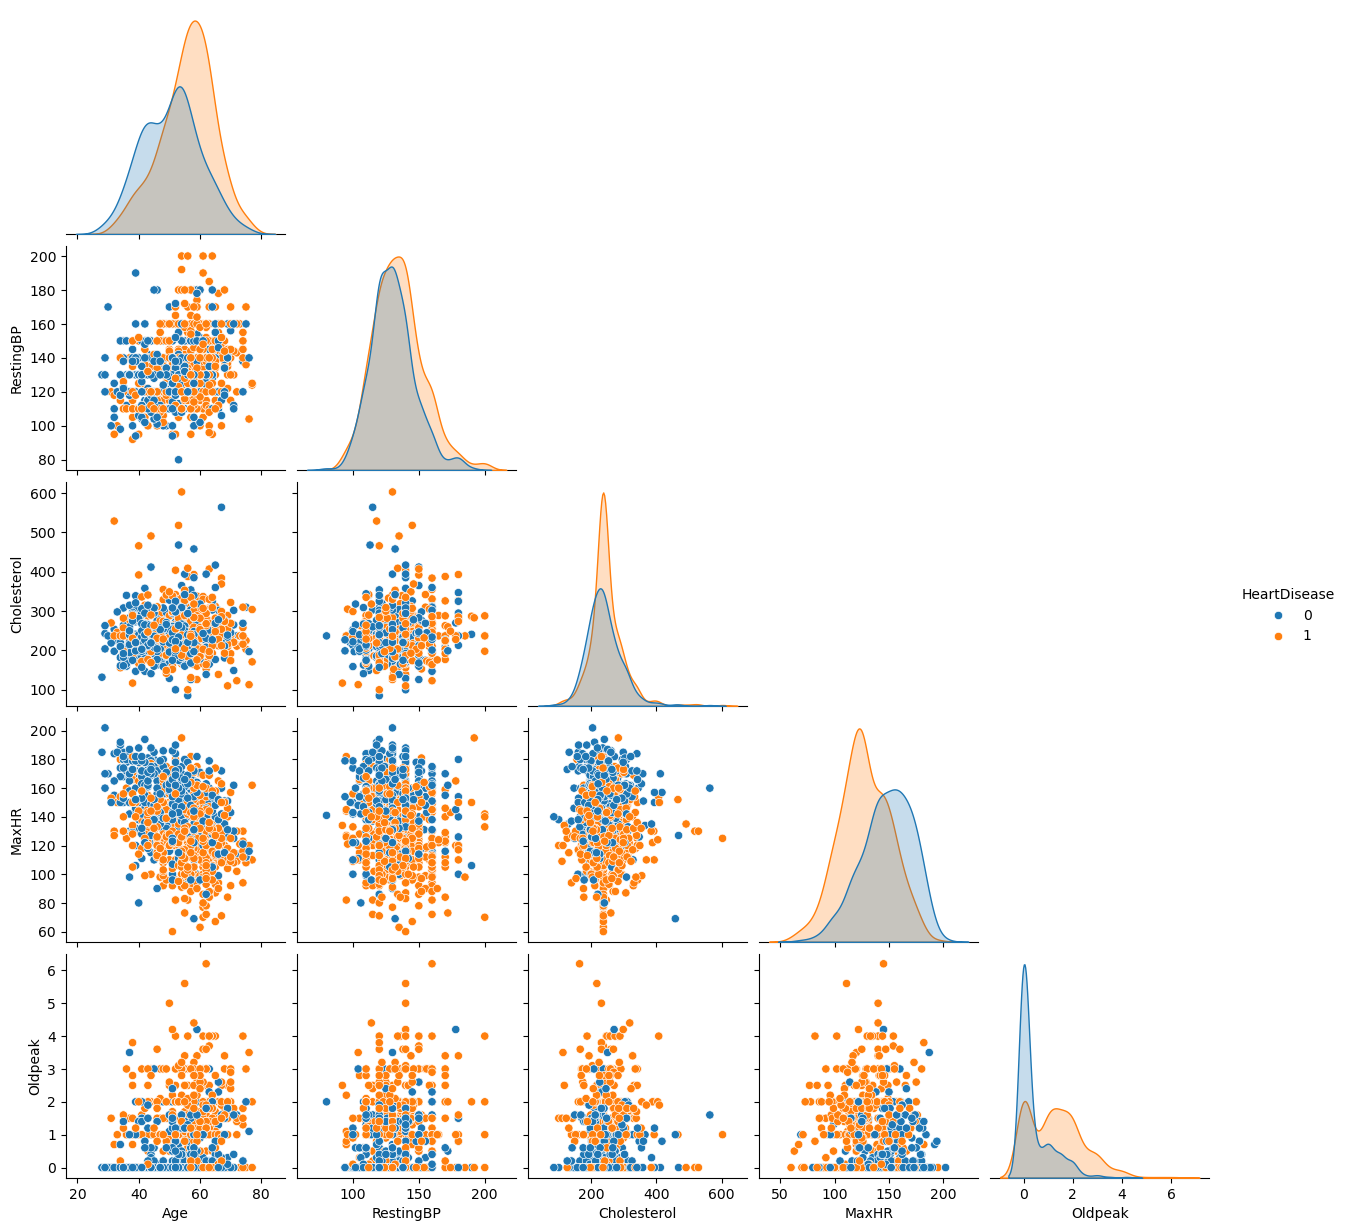

In [26]:
sns.pairplot(df.drop(columns="FastingBS"), hue="HeartDisease", corner=True)
plt.show()

There are differences between the distributions of each numerical column, based on the presence of heart disease. This suggests there are differences among these groups based on heart disease and these columns will be good predictors for heart disease. 

There were not trends between variables to spot easily.

This pairplot includes only the numerical columns, besides fasting blood sugar since it was binary.

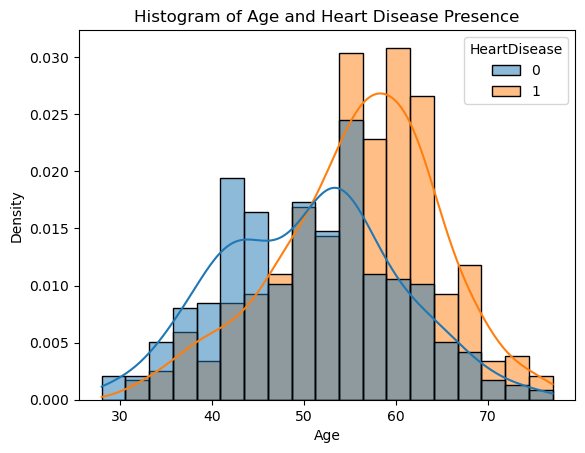

In [27]:
sns.histplot(data=df, x='Age', hue='HeartDisease', kde=True, stat="density")
plt.title("Histogram of Age and Heart Disease Presence")
plt.show()

It seems those affected by heart disease tend to be older on average.

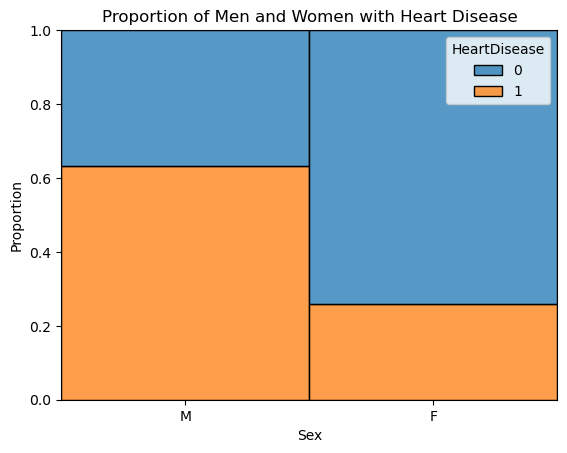

In [28]:
sns.histplot(data=df,
             x="Sex", hue="HeartDisease",
             stat="proportion",
             multiple="fill")
plt.title("Proportion of Men and Women with Heart Disease")
plt.show()

The data does not have an even amount of men and women, so proportions must be used to keep comparisons fair. Looking at the proportion of those with and without heart disease, it seems men are much more likely to suffer from heart disease than women (over double the risk!).

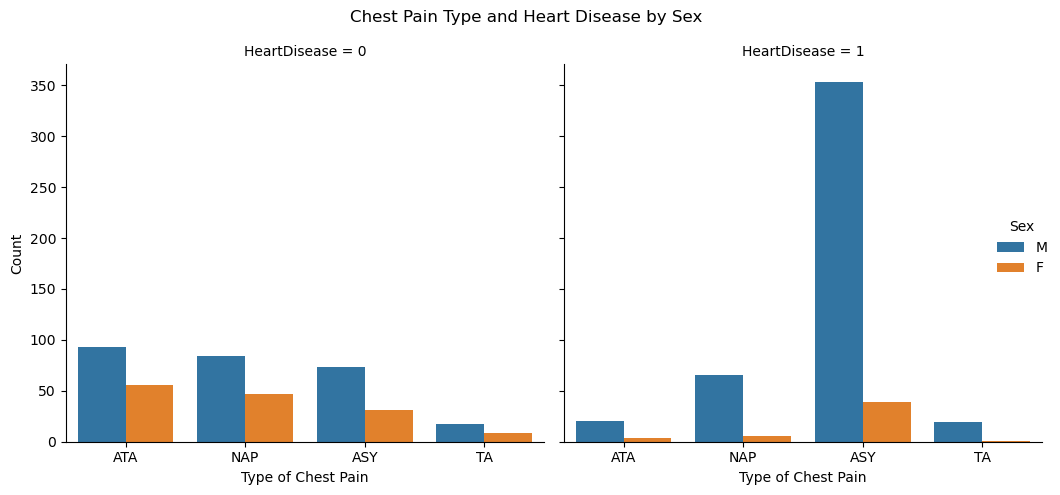

In [29]:
g = sns.catplot(data=df,
            x="ChestPainType", hue="Sex", col="HeartDisease", kind="count")

plt.suptitle("Chest Pain Type and Heart Disease by Sex")
plt.tight_layout()
g.set_axis_labels("Type of Chest Pain", "Count")
plt.show()

The most common type of chest pain for males with heart disease is asymptomatic by far. This means that chest pain alone is not a good predictor for having heart disease, and no chest pain does not mean there is no heart disease. 

Again it can be seen that women are at less risk for heart disease than men. However, asymptomatic chest pain is the most common type for women with heart disease as well. 

### Key Insights

Overall, it seems men are at higher risk for heart disease than women. Those affected tend to be older than those who are not affected. There is not a single type of chest pain that is a key indicator for heart disease. Interestingly, those with heart disease tend to exhibit asymptomatic chest pain, which is showing no symptoms. 

Additionally, those with heart disease tend to have a lower heart rate than those who do not have heart disease. When judging by oldpeak, a higher oldpeak measurement is associated with heart disease. 

There is no clear indicator for heart disease. It must be some combination of these factors.

## Logistic Regression

I created a random seed for reproducibility. Then I split my data frame, X being all predictor variables and y being the presence of heart disease. I used this split to perform am 80/20 test train split on.

Since some columns were numerical and some were categorical, I then split these so I could scale the numeric and encode the categorical. I put them back into a final data frame which was used to fit a logistic regression model and make predictions.

### Train Test Split

In [30]:
# have value for reproducibility
RANDOM_STATE = 42

In [31]:
X = df.drop(["HeartDisease"], axis=1)
y = df["HeartDisease"]

# columns for numerical and categorical values
# numerical needs to be scaled
# categorical needs to be encoded
numeric_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# scale numerical values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

# encode categorical variables
enc = OneHotEncoder(sparse_output=False, drop="first") # need to use drop to avoid multicolinearity
X_train_encoded = enc.fit_transform(X_train[categorical_cols])
X_test_encoded = enc.transform(X_test[categorical_cols])

In [32]:
# make things into a df again and put them together
# X_train
numeric_training = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
# use get feature names out since encoder adds columns
categorical_training = pd.DataFrame(X_train_encoded, columns=enc.get_feature_names_out(categorical_cols), index=X_train.index)
X_train_final = pd.concat([numeric_training, categorical_training], axis=1)

# X_test
numeric_testing = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)
categorical_testing = pd.DataFrame(X_test_encoded, columns=enc.get_feature_names_out(categorical_cols), index=X_test.index)
X_test_final = pd.concat([numeric_testing, categorical_testing], axis=1)

print(f"X train shape: {X_train_final.shape}")
print(f"X test shape: {X_test_final.shape}")

X train shape: (734, 15)
X test shape: (184, 15)


### Model Fitting and Predictions

In [33]:
# instantiate
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, )

# fit model
log_reg.fit(X_train_final, y_train)

# predict
y_pred = log_reg.predict(X_test_final)

In [34]:
# interpret coefficients
coef = pd.DataFrame({
    "Feature": X_train_final.columns,
    "Coefficient": log_reg.coef_[0],
    "Odds Ratio": np.exp(log_reg.coef_[0])
})

coef = coef.sort_values(by="Coefficient", ascending=False)
coef

,Feature,Coefficient,Odds Ratio
5,Sex_M,1.318749,3.738740
13,ST_Slope_Flat,1.125892,3.082965
9,FastingBS_1,1.083138,2.953935
12,ExerciseAngina_Y,1.010714,2.747561
4,Oldpeak,0.489353,1.631261
0,Age,0.143580,1.154399
1,RestingBP,0.009091,1.009133
10,RestingECG_Normal,0.004777,1.004788
2,Cholesterol,0.000735,1.000736
11,RestingECG_ST,-0.135010,0.873708


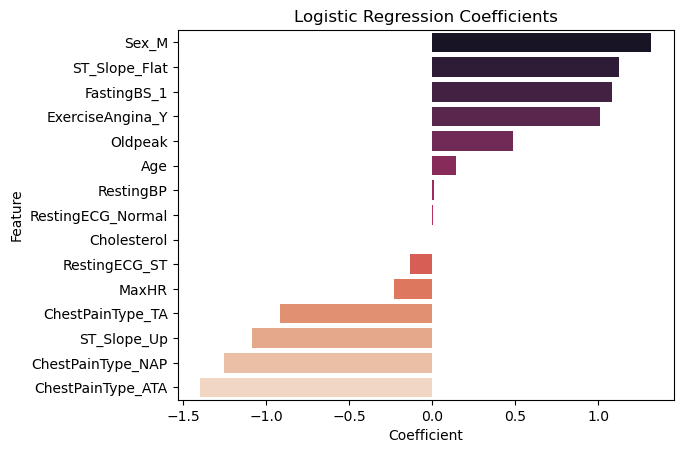

In [35]:
sns.barplot(data=coef,
            x="Coefficient", y="Feature", hue="Feature", palette="rocket")
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

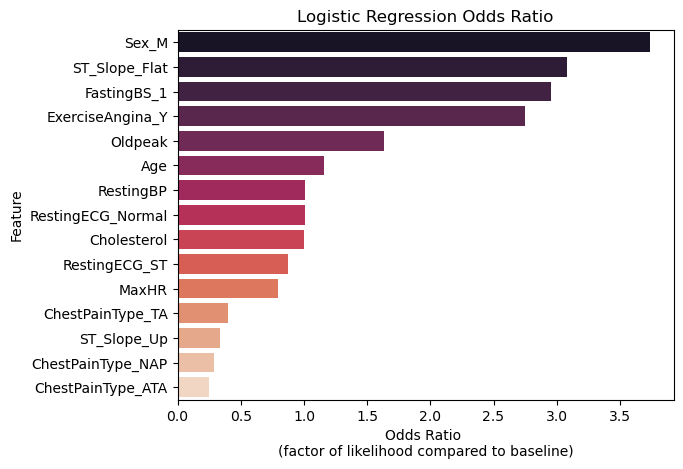

In [36]:
sns.barplot(data=coef,
            x="Odds Ratio", y="Feature", hue="Feature", palette="rocket")
plt.title("Logistic Regression Odds Ratio")
plt.xlabel("Odds Ratio \n(factor of likelihood compared to baseline)")
plt.ylabel("Feature")
plt.show()

Both the coefficients and odds ratio plots are saying the same thing. The best predictors for having heart disease are being male, a flat ST slope, high blood sugar when fasting (over 120 mg/dl), experiencing exercise angina, and a high value for oldpeak. 

Not shown but also strong predictors are a resting ECG with LVH (left ventricular hypertrophy), and asymptomatic chest pain. These are not shown because of the order the categorical variables were encoded. It is easier to tell by looking at the odds ratio. Each categorical variable is compared to the baseline, which will be whichever category came first in the data and is dropped. For example, since ChestPainType_ASY was not shown and the other chest pains are so low, asymptomatic chest pain is the strongest predictor. 

### Evaluations

In [37]:
# evaluations
acc_sc = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {round(acc_sc, 2)*100}%")

Accuracy score: 86.0%


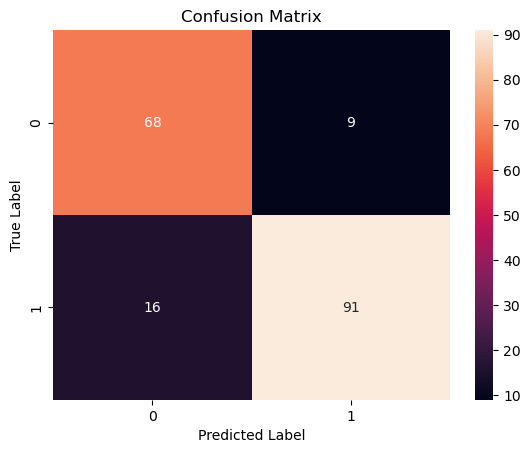

In [38]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="rocket")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [39]:
# calculate sensitivity: 
# TP / (TP + FN)
sensitivity = 92 / (92 + 17)
sensitivity * 100

print(f"Sensitivity: {round(sensitivity, 2)*100}%")

Sensitivity: 84.0%


Evaluations:

Overall, decent. Accuracy score of 86%, and sensitivity of 84%. 

Accuracy is how many times the model predicted a true value correct out of the total, so it correctly predicted 84% of positive cases.

The most important thing in a medical environment is making sure to not miss a positive diagnosis. Incorrectly labeling 16 people with heart disease as healthy is the main issue.

Moving forward, the model would need to be retrained so it does not miss a case of positive heart disease, even if it increases false positives. 

Improvements:

Instead of using all variables given as predictor variables, the next model could instead be trained only using the strong predictor variables, and the results could be compared to this model. If the performance is better, it will be a superior model. Trying cross validation and feature selection may have been helpful. 

I think this model performed well but could obviously be improved. It may work even better in conjunction with identifying high risk groups using k-means.

## K-Means Clustering

Here I used only the numerical columns. I scaled them again. Then, I used a elbow plot to pick my value for k. 

Using k=3, I fit a k-means model and then visualized a contingency table (using proportions) to evaluate it. 

After, I used PCA to visualize the three groups to examine any overlap. 

In [40]:
X = df[numeric_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

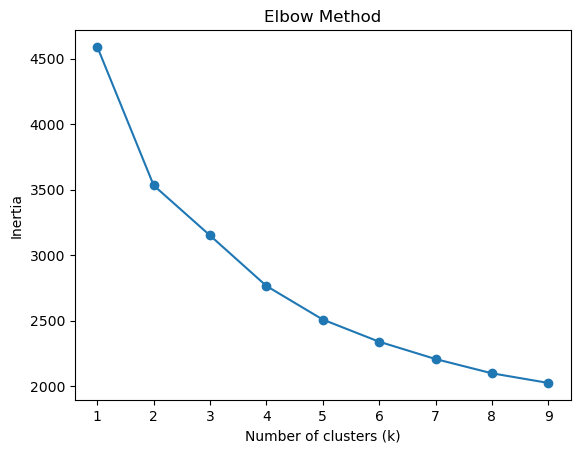

In [41]:
# elbow method for finding k
# used ChatGPT to help generate this code block
inertias = []
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [42]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)

kmeans.fit(X_scaled)

df["Cluster"] = kmeans.labels_

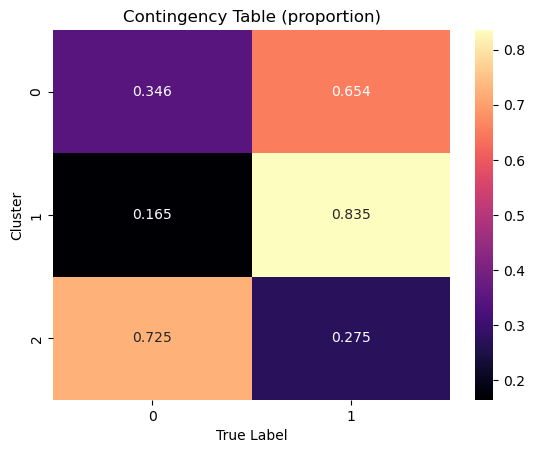

In [43]:
contingency = pd.crosstab(df["Cluster"], df["HeartDisease"], normalize="index")

sns.heatmap(contingency, annot=True, cmap='magma', fmt=".3g")
plt.title("Contingency Table (proportion)")
plt.xlabel("True Label")
plt.ylabel("Cluster")
plt.show()

Three groups here:

Cluster 0: Medium risk, 65.4% of people have heart disease. 

Cluster 1: High risk, 83.5% of people have heart disease.

Cluster 2: Low risk, only 27.5% of people have heart disease.

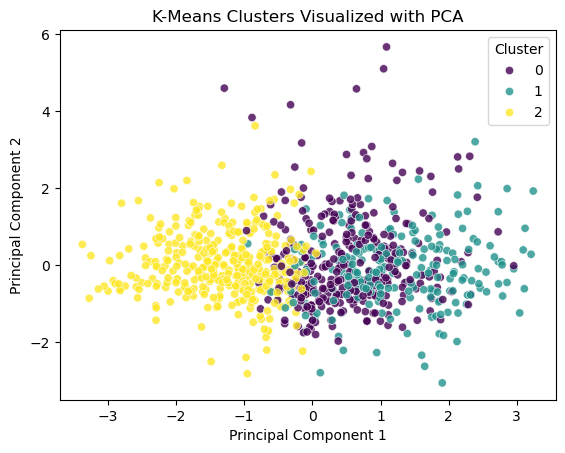

In [44]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

sns.scatterplot(
    data=df,
    x='PC1', y='PC2',
    hue='Cluster',
    alpha=0.8,
    palette="viridis")

plt.title("K-Means Clusters Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

There is overlap between clusters, but that is to be expected since there are not major differences between groups, instead there are differing factors on a wide range. There is no clear way to separate those with and without heart disease, only put them into risk groups.

The low risk group (cluster 2) is to the left, and the high risk group (cluster 1) is to the right. There is a small overlap between them. The medium risk group (cluster 0) overlaps both cluster 1 and 2, bridging the two, which is exactly what is to be expected of a medium risk group. 

### Improvements

Try including categorical variables. This may help, or may make the model worse.

## Conclusions

There is roughly a three group categorization for heart disease risk: high risk, medium risk, and low risk. This was found using kmeans. However, it is hard to categorize risk from one predictor alone, which is where logistic regression is helpful. 

From logistic regression, the most important predictors found were being male, having a flat ST slope, high fasting blood sugar, and experiencing exercise angina. Those suffering from one or more of these I would indicate as high risk, just to be cautious and not miss a potentially positive diagnosis. Better to be safe than sorry. No chest pain (asymptomatic) does not mean, by itself, that someone is not at risk for heart disease. This is why regular doctor visits are so important, just because you feel fine does not mean you are completely healthy.

Most surprising to me was that age was much less of a factor than I thought (before my EDA), how disproportionately males are at risk vs. females, and how high risk someone could be despite them being asymptomatic for chest pain. This may be part of the reason so many people die from heart disease each year. Also, how complex medical data can get. To be able to model and interpret the results effectively, you must know what each column means and what the values in the columns represent. For example, I did not know what a flat ST slope or exercise angina meant, but I needed to research them to understand what they are and their role in trying to predict heart disease. I would say that took the longest, and I had to continuously do so throughout the entirety of the project. I also see how it is difficult to predict medical conditions, and it makes sense why the preference is having a more sensitive test. Sending a patient for a second test if the first one is positive, to confirm the diagnosis, is far superior than a false negative diagnosis. 

The quality of the data was overall good. However, there were disguised missing values as zeros: one missing value for restingBP and 172 missing values for cholesterol. So out of 918 original rows, 732 needed no modification. Just about 80% of the data was already clean.

To conclude: predicting heart disease is not easy! Patients can be placed into groups of certain risk level based on their health data, but they will needed to be tested and monitored regardless. 

### Key Visualization

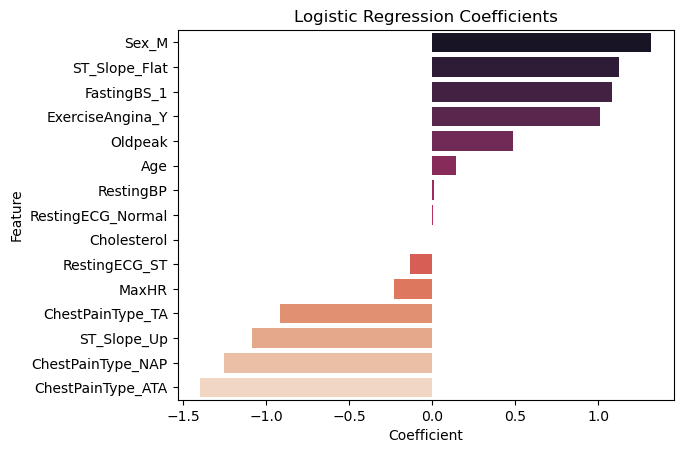

In [45]:
sns.barplot(data=coef,
            x="Coefficient", y="Feature", hue="Feature", palette="rocket")
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

## AI Usage Disclosure

I used ChatGPT to help generate the following code:

    for k in K:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        km.fit(X_scaled)
        inertias.append(km.inertia_)

I asked for help writing code for using the elbow method to select a k for k-means.

This code makes sense, it just uses a k in the range you decide, fits a k-means model, and records the intertia for that model. Then it is easy to show on a plot using K and the list for inertias. 